# Log Anomaly Detection using fine tunned LLM
Classify anomaly log sequences using fine tunned LLM for BlueGene/L supercomputer system.

## Setup and Imports

In [1]:
pip install torch transformers peft datasets pandas numpy scikit-learn pyreft seaborn matplotlib drain3

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, PeftModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
torch.cuda.empty_cache()

---

## Data preparation

#### 1. Load Data

In [6]:
# load BGL data
log_df = pd.read_csv("./data/BGL_train.csv")

In [7]:
log_df.head(1)

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected


#### 2. Data processing

In [8]:
# clean df
log_df.dropna()

# replace anomaly and normal labels to '1' & '0' respectively
log_df['Label'] = log_df['Label'].apply(lambda x: 0 if x == '-' else 1)

In [9]:
# combine columns to make it nore meaninful 
log_df['Description'] = '[' + log_df['Level'].astype(str) + '] ' + log_df['EventTemplate'].astype(str)

In [10]:
log_df.head(1)

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,Description
0,1,0,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,E77,instruction cache parity error corrected,[INFO] instruction cache parity error corrected


In [11]:
print(log_df['Label'].value_counts())

Label
0    1857
1     143
Name: count, dtype: int64


#### 3. Sequence windowing

In [12]:
# each sequence window size
window_size = 10
# how much window to slide 
stride = 3

sequences = []
labels = []

# combines 10 consecutive rows into a one sequence
for i in range(0, len(log_df) - window_size + 1, stride):
    sequence = ' '.join(log_df['Description'][i:i + window_size].astype(str))
    seq_label = log_df['Label'][i:i + window_size].max()
    sequences.append(sequence)
    labels.append(seq_label)

#### 4. Train Test split

In [13]:
# split sequences and labels into - 80% training & 20% testing
train_seqs, test_seqs, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42
)

print(f"Total sequences: {len(train_seqs) + len(test_seqs)}")
print(f"Train sequences: {len(train_seqs)} | Anomalous: {sum(train_labels)} ({sum(train_labels)/len(train_labels)*100:.2f}%)")
print(f"Test sequences: {len(test_seqs)} | Anomalous: {sum(test_labels)} ({sum(test_labels)/len(test_labels)*100:.2f}%)")

Total sequences: 664
Train sequences: 531 | Anomalous: 98 (18.46%)
Test sequences: 133 | Anomalous: 32 (24.06%)


In [14]:
# extract anomaly sequences
anomaly_seqs = [seq for seq, label in zip(train_seqs, train_labels) if label == 1]

---

## Tokenization & Dataset creation

#### 1. Setup tokenizer

In [15]:
llm_model = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(llm_model)

# utility function to convert logs into model ready inputs 
def tokenize_sequences(sequences, tokenizer, max_length=512):
    return tokenizer(
        sequences,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

#### 2. Dataset creation

In [16]:
# convert to PyTorch dataset
class LogDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

#### 3. Tokenize sequences

In [17]:
# tokenize
train_encodings = tokenize_sequences(train_seqs, tokenizer)
test_encodings = tokenize_sequences(test_seqs, tokenizer)

# create datasets
train_dataset = LogDataset(train_encodings, train_labels)
test_dataset = LogDataset(test_encodings, test_labels)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

---

## Model Training

#### 1. Prepare model training

In [18]:
CLASSIFICATION_MODEL_LOCATION="./model/classifier/anomaly_classifier"

In [20]:
# function to train the model
def train_model(model, train_loader, test_loader, device, epochs=10, patience=5):
    model.to(device)
    # intialise AdamW optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    # small learning rate so it won’t overshoot
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # handle classs imbalance with higher weight
    # weighted loss to penalize for misclassifying the minority class
    class_weights = torch.tensor([1.0, 6.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
        
    # track early stopping
    best_f1 = 0
    patience_counter = 0

    print(f"\nTraining... | No. of Epochs: {epochs}...\n")
    
    # Train model
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:

            # reset gradient
            optimizer.zero_grad()

            # Get the input data and labels from the batch, move them to the device (GPU/CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            
            # calculate loss
            loss = criterion(outputs.logits, labels)
                        
            # backward pass
            loss.backward()
                        
            # update model weight
            optimizer.step()

            # Accumulate the loss for logging purposes
            total_loss += loss.item()

        # adjust learning rate
        scheduler.step()
        # average loss for the epoch
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
        
        # Evaluate to check for early stopping
        f1, _, _, _ = evaluate_model(model, test_loader, device)
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            model.save_pretrained(CLASSIFICATION_MODEL_LOCATION)
            tokenizer.save_pretrained(CLASSIFICATION_MODEL_LOCATION)
            print("\n########################################\n")
        else:
            # If no improvement in F1 score, stop training early
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping...\n")
                break

#### 2. Prepare model evaluation

In [21]:
# evaluate model performance with threshold
def evaluate_model(model, test_loader, device, threshold=0.1039):
    # evaluate
    model.eval()
    predictions = []
    true_labels = []

    # disable gradient
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits[:, 1]  # Score for class 1

            # predict anomaly
            preds = (logits > threshold).cpu().numpy().astype(int)

            # store predeiction
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    # calcuate metrics
    f1 = f1_score(true_labels, predictions, zero_division=0)
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    
    print(f"\nF1: {f1:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\n")
    print(f"Confusion Matrix:\n {confusion_matrix(true_labels, predictions)}\n")
    return f1, precision, recall, predictions

#### 3. Initialise model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model
model = AutoModelForSequenceClassification.from_pretrained(
    llm_model,
    num_labels=2,
    pad_token_id=tokenizer.pad_token_id
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 4. Setup Lora

In [23]:
# define lora
lora_config = LoraConfig(
    task_type="SEQ_CLS", # for binary classification
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj", "k_proj"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 6,131,712 || all params: 1,040,648,192 || trainable%: 0.5892


#### 5. Train model

In [24]:
# train model
train_model(model, train_loader, test_loader, device, epochs=10, patience=5)


Training... | No. of Epochs: 10...

Epoch 1, Loss: 0.37547447665858624

F1: 0.7294
Precision: 0.5849
Recall: 0.9688

Confusion Matrix:
 [[79 22]
 [ 1 31]]


########################################

Epoch 2, Loss: 0.1091395245088306

F1: 0.9062
Precision: 0.9062
Recall: 0.9062

Confusion Matrix:
 [[98  3]
 [ 3 29]]


########################################

Epoch 3, Loss: 0.04279728729535005

F1: 0.8857
Precision: 0.8158
Recall: 0.9688

Confusion Matrix:
 [[94  7]
 [ 1 31]]

Epoch 4, Loss: 0.01676592217081091

F1: 0.9697
Precision: 0.9412
Recall: 1.0000

Confusion Matrix:
 [[99  2]
 [ 0 32]]


########################################

Epoch 5, Loss: 0.001822015946379282

F1: 0.9697
Precision: 0.9412
Recall: 1.0000

Confusion Matrix:
 [[99  2]
 [ 0 32]]

Epoch 6, Loss: 0.0007382053914191045

F1: 0.9697
Precision: 0.9412
Recall: 1.0000

Confusion Matrix:
 [[99  2]
 [ 0 32]]

Epoch 7, Loss: 0.0006776269121691081

F1: 0.9697
Precision: 0.9412
Recall: 1.0000

Confusion Matrix:
 [[99  2]
 

---

## Modal Evaluation

#### 1. Evaluate model

In [25]:
# load model
tokenizer = AutoTokenizer.from_pretrained(CLASSIFICATION_MODEL_LOCATION)
model = AutoModelForSequenceClassification.from_pretrained(llm_model, num_labels=2, pad_token_id=tokenizer.pad_token_id)
model = PeftModel.from_pretrained(model, CLASSIFICATION_MODEL_LOCATION)
model.to(device)

# evaluate
_, _, _, predictions = evaluate_model(model, test_loader, device, threshold=0.1039)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



F1: 0.9697
Precision: 0.9412
Recall: 1.0000

Confusion Matrix:
 [[99  2]
 [ 0 32]]



#### 2. Evaluate with threshold tuning

In [26]:
# find best threshold based on F1 score
def evaluate_model_with_threshold(model, test_loader, device):
    # evaluate
    model.eval()
    logits = []
    true_labels = []
    
    # disable gradient
    with torch.no_grad():
        for batch in test_loader:
            # move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            logits.extend(outputs.logits[:, 1].cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
    from sklearn.metrics import precision_recall_curve

    # calculate precision & recall
    precisions, recalls, thresholds = precision_recall_curve(true_labels, logits)
    # F1 score
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    # index of best F1 score
    best_idx = f1_scores.argmax()

    # best threshold
    best_threshold = thresholds[best_idx]
    
    print(f"\nBest F1: {f1_scores[best_idx]:.4f}\nPrecision: {precisions[best_idx]:.4f}\n"
          f"Recall: {recalls[best_idx]:.4f}\nThreshold: {best_threshold:.4f}\n")

    return true_labels, logits, best_threshold

In [27]:
# find best threshold
true_labels, logits, best_threshold = evaluate_model_with_threshold(model, test_loader, device)


Best F1: 0.9841
Precision: 1.0000
Recall: 0.9688
Threshold: 1.4070



#### 3. Plot Precission Recall curve

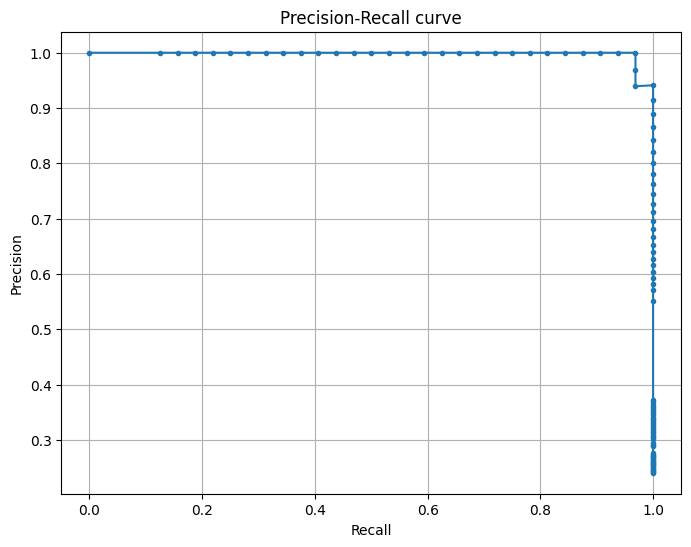

In [28]:
# calculate & plot
precisions, recalls, thresholds = precision_recall_curve(true_labels, logits)
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.grid()
plt.show()

---

## Fine-tuning LLM for reasoning

In [29]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 1. Load dataset & create train test split
Created reasoning for each anomaly sequence and a synthetic dataset can be created by running the script `synthetic_log_explaination.py`

In [30]:
!python ./synthetic_log_explaination.py

Created a dataset with 98 sequences & 98 of their reasons, & stored in './data/anomaly_explantion.csv'


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
# load dataset
reasoning_df = pd.read_csv('./data/anomaly_explantion.csv')
reasoning_df.head(1)

,sequence,reason
0,[FATAL] Lustre mount FAILED : bglio<*> : point...,"Storage mount failures, debugger crashes, and ..."


In [32]:
# train test split
train_reasoning, test_reasoning = train_test_split(
    reasoning_df, test_size=0.2, random_state=42
)

#### 2. Create custom dataset

In [33]:
class ReasoningDataset(Dataset):
    def __init__(self, sequences, reasons, tokenizer, max_length=512):
        self.sequences = sequences
        self.reasons = reasons
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        reason = self.reasons[idx]
        text = f"Sequence: {sequence} Reason: {reason}"
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': encodings['input_ids'].squeeze()
        }

#### 3. Load Tokenizer and create dataset

In [34]:
reasoning_model = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

In [35]:
# load tokenizer
tokenizer_reasoning = AutoTokenizer.from_pretrained(reasoning_model)
    
if tokenizer_reasoning.pad_token is None:
    tokenizer_reasoning.pad_token = tokenizer.eos_token
    tokenizer_reasoning.padding_side = 'left'

In [36]:
# create reasoning dataset
train_reasoning_dataset = ReasoningDataset(
    train_reasoning['sequence'].tolist(),
    train_reasoning['reason'].tolist(),
    tokenizer_reasoning
)
test_reasoning_dataset = ReasoningDataset(
    test_reasoning['sequence'].tolist(),
    test_reasoning['reason'].tolist(),
    tokenizer_reasoning
)

#### 4. Load model

In [37]:
# load model
reasoning_model = AutoModelForCausalLM.from_pretrained(reasoning_model)
reasoning_model.tokenizer = tokenizer_reasoning

#### 5. Setup lora

In [38]:
# configure lora
reasoning_lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj", "k_proj"]
)

reasoning_model = get_peft_model(reasoning_model, reasoning_lora_config)
reasoning_model.print_trainable_parameters()

trainable params: 6,127,616 || all params: 1,106,176,000 || trainable%: 0.5539


#### 6. Train model

In [39]:
# define training args
reasoning_training_args = TrainingArguments(
    output_dir="./model/reasoning/checkpoints",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

# train model
reasoning_trainer = Trainer(
    model=reasoning_model,
    args=reasoning_training_args,
    train_dataset=train_reasoning_dataset,
    eval_dataset=test_reasoning_dataset,
    tokenizer=tokenizer_reasoning
)
reasoning_trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss
20,6.327400,4.973135
40,2.711100,2.060183
60,0.792300,0.767085
80,0.613600,0.677140
100,0.551100,0.599949
120,0.437600,0.536610
140,0.412900,0.495266
160,0.339300,0.467832
180,0.378900,0.453830
200,0.327900,0.449233


TrainOutput(global_step=200, training_loss=1.4501865983009339, metrics={'train_runtime': 462.3836, 'train_samples_per_second': 1.687, 'train_steps_per_second': 0.433, 'total_flos': 2493539942400000.0, 'train_loss': 1.4501865983009339, 'epoch': 10.0})

#### 7. Save model

In [40]:
# save model
reasoning_model.save_pretrained("./model/reasoning/anomaly_reasoning")
tokenizer_reasoning.save_pretrained("./model/reasoning/anomaly_reasoning")

('./model/reasoning/anomaly_reasoning/tokenizer_config.json',
 './model/reasoning/anomaly_reasoning/special_tokens_map.json',
 './model/reasoning/anomaly_reasoning/tokenizer.model',
 './model/reasoning/anomaly_reasoning/added_tokens.json',
 './model/reasoning/anomaly_reasoning/tokenizer.json')

#### 8. Evaluate model

In [41]:
# function to evaluate the reasoning model
def evaluate_reasoning_model(model, tokenizer, dataset, device):
    
    # model evaluation
    model.eval()
    
    for i in range(min(5, len(dataset))):
        sequence = dataset.sequences[i]
        true_reason = dataset.reasons[i]
        prompt = f"Sequence: {sequence} Reason:"
        inputs = tokenizer(prompt, return_tensors='pt').to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=50,
                pad_token_id=tokenizer.pad_token_id
            )
        generated_reason = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):].strip()
        
        print(f"\nSample {i + 1}:")
        print(f"\nSequence: {sequence[:100]}...")
        print(f"\nTrue Reason: {true_reason}")
        print(f"\nGenerated Reason: {generated_reason}\n")
        print("##################")

In [42]:
# evaluate
evaluate_reasoning_model(
    reasoning_model,
    tokenizer_reasoning,
    test_reasoning_dataset,
    device
)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



Sample 1:

Sequence: [FATAL] Error loading program image (Permission denied), retransmission errors, multiple received si...

True Reason: Permission denied errors when loading programs, combined with network retransmission faults and Lustre failures, point to storage and communication breakdown.

Generated Reason: Lustre mount failure, repeated permission denial errors, and multiple received signals indicate severe system instability.

##################

Sample 2:

Sequence: [FATAL] data TLB error interrupt [FATAL] data TLB error interrupt ... (10 times total)...

True Reason: Massive repeated TLB errors indicate complete breakdown of memory address translation subsystem, critically affecting system operation.

Generated Reason: Massive data TLB errors indicate severe memory corruption and system instability.

##################

Sample 3:

Sequence: [FATAL] kernel termination due to bad message header, debug wait hangs, floating point alignment exc...

True Reason: Bad message head

---

## Model Inference

In [43]:
from drain3.template_miner_config import TemplateMinerConfig
from drain3.template_miner import TemplateMiner

#### 1. Load test logs and clean

In [44]:
log_file_path = "./data/test.log"
with open(log_file_path, "r") as file:
    logs = file.readlines()

In [45]:
# data cleanup
# drain3: used to encode dynamic fields in raw logs
config = TemplateMinerConfig()
template_miner = TemplateMiner(config=config)

test_logs = []
for line in logs:
    result = template_miner.add_log_message(line)
    if result is not None:
        test_logs.append(result["template_mined"])

print(test_logs[1])

- <*> 2005.06.03 R02-M1-N0-C:J12-U11 <*> R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected


#### 2. Sequence generation

In [46]:
# sliding window
window_size = 10
stride = 3

# Generate sequences
sequences = []
for i in range(0, len(test_logs) - window_size + 1, stride):
    sequence = ' '.join(test_logs[i:i + window_size])
    sequences.append(sequence)

print(sequences[0])

- 1117838570 2005.06.03 R02-M1-N0-C:J12-U11 2005-06-03-15.42.50.675872 R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected - <*> 2005.06.03 R02-M1-N0-C:J12-U11 <*> R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected - <*> 2005.06.03 R02-M1-N0-C:J12-U11 <*> R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected - <*> 2005.06.03 R02-M1-N0-C:J12-U11 <*> R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected - 1117842440 2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.47.20.730545 R23-M0-NE-C:J05-U01 RAS KERNEL INFO 63543 double-hummer alignment exceptions - <*> 2005.06.03 <*> <*> <*> RAS KERNEL INFO <*> double-hummer alignment exceptions - <*> 2005.06.03 <*> <*> <*> RAS KERNEL INFO <*> double-hummer alignment exceptions - 1117848119 2005.06.03 R16-M1-N2-C:J17-U01 2005-06-03-18.21.59.871925 R16-M1-N2-C:J17-U01 RAS KERNEL INFO CE sym 2, at 0x0b85eee0, mask 0x05 APPREAD 1117869872 2005.06.04 R04-M1-N4-

#### 3. Create dataset

In [47]:
class LogDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

#### 4. Tokenize

In [48]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CLASSIFICATION_MODEL_LOCATION)

def tokenize_sequences(sequences, tokenizer, max_length=512):
    return tokenizer(
        sequences,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

In [49]:
# tokenize
encodings = tokenize_sequences(sequences, tokenizer)
dataset = LogDataset(encodings, [0] * len(sequences))
loader = DataLoader(dataset, batch_size=8, shuffle=False)

####  5. Load model

In [50]:
classification_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define classfication model
base_model = AutoModelForSequenceClassification.from_pretrained(
    classification_model_name,
    num_labels=2,
    pad_token_id=tokenizer.pad_token_id
)

# load the model
classification_model = PeftModel.from_pretrained(base_model, CLASSIFICATION_MODEL_LOCATION)
classification_model.to(device)
classification_model.eval()

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048, padding_idx=2)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
      

In [51]:
# load reasoning model
reasoning_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
reasoning_model = AutoModelForCausalLM.from_pretrained(reasoning_model_name)
reasoning_model = PeftModel.from_pretrained(reasoning_model, "./model/reasoning/anomaly_reasoning")
reasoning_model.to(device)
reasoning_model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Line

#### 6. Inference

In [52]:
# is anomaly?
predictions = []
with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = classification_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits[:, 1]
        preds = (logits > 0.1039).cpu().numpy().astype(int)
        predictions.extend(preds)

In [53]:
# generate explanation for the detected anomalies
max_new_tokens=20
anomalous_sequences = []
output = []

for i, (seq, pred) in enumerate(zip(sequences, predictions)):
    explanation = ""
    if pred == 1:
        prompt = f"Sequence: {seq} Reason:"
        inputs = tokenizer(prompt, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = reasoning_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                pad_token_id=tokenizer.pad_token_id
                )
        explanation = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):].strip()
        anomalous_sequences.append((seq, explanation)) # store anomalies
    output.append((seq, explanation, pred)) # normal and anomaly data   

In [54]:
anomalous_sequences[0]

('- <*> 2005.06.03 R02-M1-N0-C:J12-U11 <*> R02-M1-N0-C:J12-U11 RAS KERNEL INFO instruction cache parity error corrected - 1117842440 2005.06.03 R23-M0-NE-C:J05-U01 2005-06-03-16.47.20.730545 R23-M0-NE-C:J05-U01 RAS KERNEL INFO 63543 double-hummer alignment exceptions - <*> 2005.06.03 <*> <*> <*> RAS KERNEL INFO <*> double-hummer alignment exceptions - <*> 2005.06.03 <*> <*> <*> RAS KERNEL INFO <*> double-hummer alignment exceptions - 1117848119 2005.06.03 R16-M1-N2-C:J17-U01 2005-06-03-18.21.59.871925 R16-M1-N2-C:J17-U01 RAS KERNEL INFO CE sym 2, at 0x0b85eee0, mask 0x05 APPREAD 1117869872 2005.06.04 R04-M1-N4-I:J18-U11 2005-06-04-00.24.32.432192 R04-M1-N4-I:J18-U11 RAS APP FATAL ciod: failed to read message prefix on control stream (CioStream socket to 172.16.96.116:33569 APPREAD <*> 2005.06.04 <*> <*> <*> RAS APP FATAL ciod: failed to read message prefix on control stream (CioStream socket to <*> - <*> <*> <*> <*> <*> RAS KERNEL INFO CE sym <*> at <*> mask <*> - 1117955341 2005.06.05

#### 7. Store model output as csv

In [55]:
df = pd.DataFrame(output, columns=['Sequence', 'Explanation', 'Prediction'])
df.to_csv('./data/output.csv')

---